# QCoDeS tutorial 
Basic overview of QCoDeS

## Table of Contents <a class="anchor" id="toc"></a>
  * [Workflow](#workflow)
  * [Basic instrument interaction](#inst_io)
  * [Measuring](#measurement)
    * [The loop: 1D example](#loop_1D)
    * [The loop: 2D example](#loop_2D)


## Typical QCodes workflow <a class="anchor" id="workflow"></a>
(back to [ToC](#toc))

1. Start up an interactive python session (e.g. using jupyter) 
2. import desired modules 
3. instantiate required instruments 
4. experiment! 

### Importing

In [1]:
# usually, one imports QCoDeS and some instruments
import qcodes as qc
from qcodes.plots.pyqtgraph import QtPlot
from qcodes.plots.qcmatplotlib import MatPlot
# In this tutorial, we import the dummy instrument
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.loops import Loop
from qcodes.data.data_set import load_data
# real instruments are imported in a similar way, e.g.
# from qcodes.instrument_drivers.Keysight.KeysightAgilent_33XXX import WaveformGenerator_33XXX

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210517-17310-qcodes.log


### Instantiation of instruments

In [2]:
# It is not enough to import the instruments, they must also be instantiated
# Note that this can only be done once. If you try to re-instantiate an existing instrument, QCoDeS will 
# complain that 'Another instrument has the name'.


# In this turotial, we consider a simple situation: A single DAC outputting voltages to a Digital Multi Meter

dac = DummyInstrument(name="dac", gates=['ch1', 'ch2'])  # The DAC voltage source
dmm = DummyInstrument(name="dmm", gates=['voltage'])  # The DMM voltage reader

# the default dummy instrument returns always a constant value, in the following line we make it random 
# just for the looks 💅
import random
dmm.voltage.get =  lambda: random.randint(0, 100)

# Finally, the instruments should be bound to a Station. Only instruments bound to the Station get recorded in the
# measurement metadata, so your metadata is blind to any instrument not in the Station.

station = qc.Station(dac, dmm)

In [3]:
# For the tutorial, we add a parameter that loudly prints what it is being set to
# (It is used below)

chX = 0

def myget():
    return chX
    
def myset(x):
    global chX
    chX = x
    print('Setting to {}'.format(x))
    return None
    
dac.add_parameter('verbose_channel',
                  label='Verbose Channel',
                  unit='V',
                  get_cmd=myget,
                  set_cmd=myset)

### The location provider can be set globally 

In [4]:
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

We are now ready to play with the instruments!

## Basic instrument interaction <a class="anchor" id="inst_io"></a>
(back to [ToC](#toc))

The interaction with instruments mainly consists of `setting` and `getting` the instruments' `parameters`. A parameter can be anything from the frequency of a signal generator over the output impedance of an AWG to the traces from a lock-in amplifier. In this tutorial we --for didactical reasons-- only consider scalar parameters. 

In [5]:
# The voltages output by the dac can be set like so
dac.ch1.set(8)  
# Now the output is 8 V. We can read this value back
dac.ch1.get()

8

Setting IMMEDIATELY changes a value. For voltages, that is sometimes undesired. The value can instead be ramped by stepping and waiting.

In [6]:
dac.verbose_channel.set(0) 
dac.verbose_channel.set(9)  # immediate voltage jump of 9 Volts (!)

# first set a step size
dac.verbose_channel.step = 0.1
# and a wait time
dac.verbose_channel.inter_delay = 0.01 # in seconds

# now a "staircase ramp" is performed by setting
dac.verbose_channel.set(5)

# after such a ramp, it is a good idea to reset the step and delay
dac.verbose_channel.step = 0
# and a wait time
dac.verbose_channel.inter_delay = 0 

Setting to 0
Setting to 9
Setting to 8.9
Setting to 8.8
Setting to 8.7
Setting to 8.6
Setting to 8.5
Setting to 8.4
Setting to 8.3
Setting to 8.2
Setting to 8.1
Setting to 8.0
Setting to 7.9
Setting to 7.8
Setting to 7.7
Setting to 7.6
Setting to 7.5
Setting to 7.4
Setting to 7.3
Setting to 7.2
Setting to 7.1


Setting to 7.0
Setting to 6.9
Setting to 6.8
Setting to 6.699999999999999
Setting to 6.6
Setting to 6.5
Setting to 6.4
Setting to 6.3
Setting to 6.199999999999999
Setting to 6.1
Setting to 6.0
Setting to 5.9
Setting to 5.8
Setting to 5.699999999999999
Setting to 5.6
Setting to 5.5
Setting to 5.4
Setting to 5.3
Setting to 5.199999999999999
Setting to 5.1


Setting to 5


<span style="color:blue">**NOTE**</span>: that is ramp is blocking and has a low resolution since each `set` on a real instrument has a latency on the order of ms. Some instrument drivers support native-resolution asynchronous ramping. Always refer to your instrument driver if you need high performance of an instrument.

## Measuring <a class="anchor" id="measurement"></a>
(back to [ToC](#toc))

### 1D Loop example

#### Defining the `Loop` and actions

Before you run a measurement loop you do two things:
1. You describe what parameter(s) to vary and how. This is the creation of a `Loop` object: `loop = Loop(sweep_values, ...)`
2. You describe what to do at each step in the loop. This is `loop.each(*actions)` 
  - measurements (any object with a `.get` method will be interpreted as a measurement)
  - `Task`: some callable (which can have arguments with it) to be executed each time through the loop. Does not generate data.
  - `Wait`: a specialized `Task` just to wait a certain time.
  - `BreakIf`: some condition that, if it returns truthy, breaks (this level of) the loop

In [7]:
# For instance, sweep a dac voltage and record with the dmm

loop = Loop(dac.ch1.sweep(0, 20, 0.1), delay=0.001).each(dmm.voltage)
data = loop.get_data_set(name='testsweep')

In [8]:
plot_1d = QtPlot()  # create a plot
plot_1d.add(data.dmm_voltage)  # add a graph to the plot
_ = loop.with_bg_task(plot_1d.update, plot_1d.save).run()  # run the loop

Started at 2021-05-17 10:16:58


DataSet:
   location = 'data/2021-05-17/#012_testsweep_10-16-55'
   <Type>   | <array_id>  | <array.name> | <array.shape>
   Setpoint | dac_ch1_set | ch1          | (201,)
   Measured | dmm_voltage | voltage      | (201,)
Finished at 2021-05-17 10:17:07


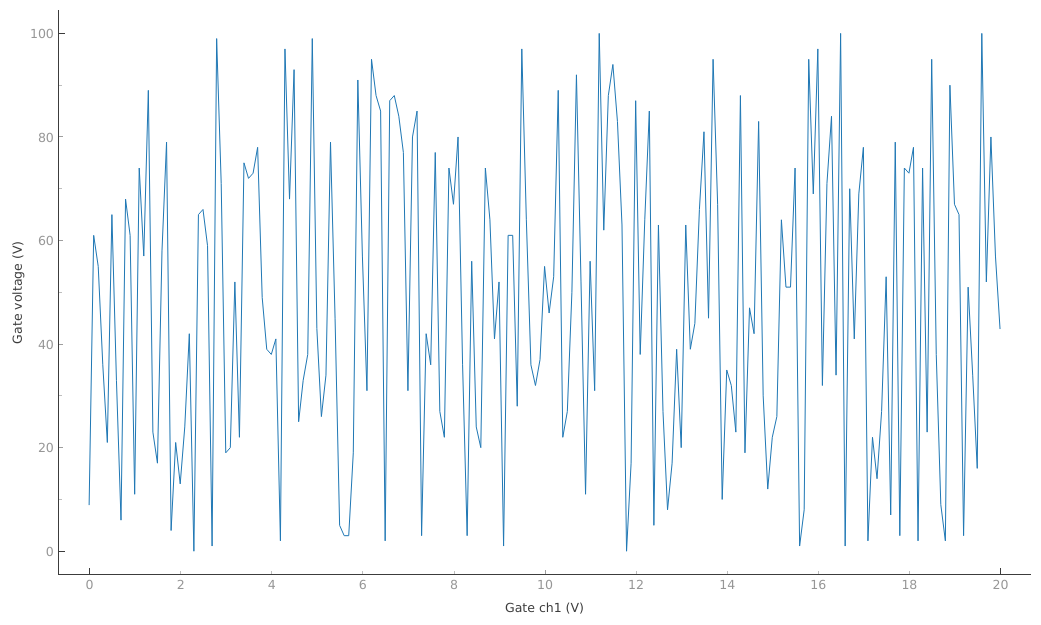

In [9]:
# The plot may be recalled easily
plot_1d

#### Output of the loop

* A loop returns a dataset.
* The representation of the dataset shows what arrays it contains and where it is saved.
* The dataset initially starts out empty (filled with NAN's) and get's filled while the Loop get's executed.

Once the measurement is done, take a look at the file in finder/explorer (the dataset.location should give you the relative path). 
Note also the snapshot that captures the settings of all instruments at the start of the Loop. 
This metadata is also accesible from the dataset and captures a snapshot of each instrument listed in the station. 

In [10]:
dac.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'qcodes.tests.instrument_mocks.DummyInstrument',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'dac_IDN',
   'value': {'vendor': None, 'model': 'dac', 'serial': None, 'firmware': None},
   'raw_value': {'vendor': None,
    'model': 'dac',
    'serial': None,
    'firmware': None},
   'ts': '2021-05-17 10:16:55',
   'vals': '<Anything>',
   'inter_delay': 0,
   'unit': '',
   'label': 'IDN',
   'instrument': 'qcodes.tests.instrument_mocks.DummyInstrument',
   'instrument_name': 'dac',
   'name': 'IDN',
   'post_delay': 0},
  'ch1': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'dac_ch1',
   'value': 20.0,
   'raw_value': 20.0,
   'ts': '2021-05-17 10:17:07',
   'vals': '<Numbers -800<=v<=400>',
   'inter_delay': 0,
   'unit': 'V',
   'label': 'Gate ch1',
   'instrument': 'qcodes.tests.instrument_mocks.DummyInstrument',
   'instrument_name': 'dac',
   'name': 'ch1',

There is also a more human-readable version of the essential information.

In [11]:
dac.print_readable_snapshot()

dac:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': None, 'model': 'dac', 'serial': None, 'firmware'...
ch1             :	20 (V)
ch2             :	0 (V)
verbose_channel :	5 (V)


## Loading data

The dataset knows its own location, which we may use to load data.

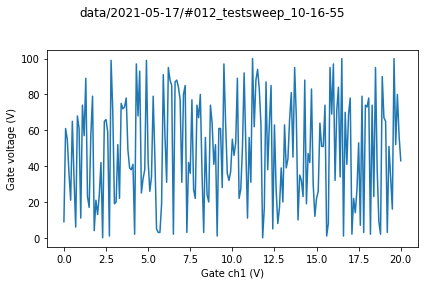

In [12]:

location = data.location
loaded_data = load_data(location)
plot = MatPlot(loaded_data.dmm_voltage)


## Example: multiple 2D measurements with live plotting

In [13]:
# Loops can be nested, so that a new sweep runs for each point in the outer loop

loop = Loop(dac.ch1.sweep(0, 5, 1), 0.1).loop(dac.ch2.sweep(0, 5, 1), 0.1).each(
    dmm.voltage
    )
data = loop.get_data_set(name='2D_test')

In [14]:
plot = QtPlot()
plot.add(data.dmm_voltage, figsize=(1200, 500))
_ = loop.with_bg_task(plot.update, plot.save).run()

Started at 2021-05-17 10:17:09


DataSet:
   location = 'data/2021-05-17/#013_2D_test_10-17-08'
   <Type>   | <array_id>  | <array.name> | <array.shape>
   Setpoint | dac_ch1_set | ch1          | (6,)
   Setpoint | dac_ch2_set | ch2          | (6, 6)
   Measured | dmm_voltage | voltage      | (6, 6)
Finished at 2021-05-17 10:17:14


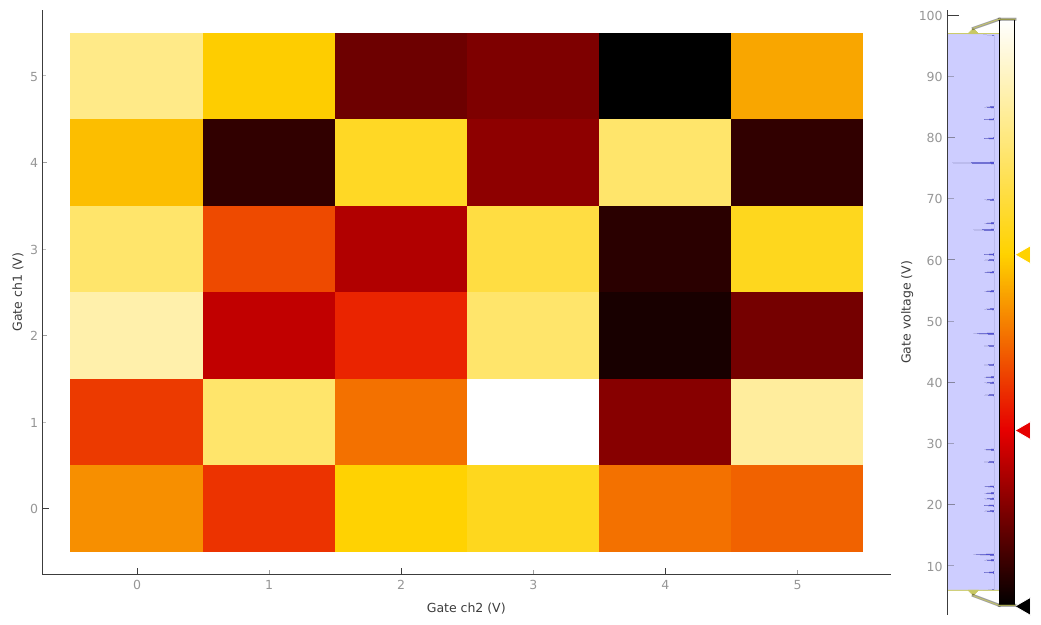

In [15]:
plot